In [25]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
import numpy as np
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors

# np.bool_ = np.bool8

NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[ np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
) -> Tuple[NP1DF8, NP1DF8, float]:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs+1
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d / 2, s)
    return rec, x_int, d

def calculate_analytic_signal(
    g_in: NP1DF8,
    x_int: NP1DF8,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
):
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * g_in[i] * np.exp(1j * phi_t)
    return g_in_an

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def normalize_and_slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16,
    axhl: int,
    offset: int,
    unit_cell_size: int,
) -> NP2DF8:
    # newField2 = np.abs(np.real(newField[:,:])+np.imag(newField[:,:]))
    newField2 = np.real(newField) ** 2 + np.imag(newField) ** 2
    newField2 = newField2[
        int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl + offset//unit_cell_size
    ]
    return newField2

def calculate_truth_table(
    distance_between_inputs: float,
    max_i: List[float], 
    number_of_inputs: int,
    input_width: int,
    unite_cell_size: int
    ) -> TT_TYPE:
    truth_table = np.zeros(number_of_inputs-1)
    for i in range(0, number_of_inputs-1):
        if any((i+0.5)*distance_between_inputs + input_width/2
               <= element*unite_cell_size <= 
               (i+1.5)*distance_between_inputs - input_width/2 for element in max_i):
            truth_table[i] = 1
    return truth_table

def get_talbot_length(
    distance_between_inputs: int,  # nm
    wavelength: float, # nm
    input_width: int,  # nm
    unit_cell_size: int,  # nm
):
    if (
        distance_between_inputs % unit_cell_size != 0
        or input_width % unit_cell_size != 0
    ):
        raise ValueError(
            f"All length parameters must be divisible by {unit_cell_size}."
        )

    # round to the nearest multiple of unit_cell_size
    talbot_length = (
        (2 * distance_between_inputs**2 / wavelength) // unit_cell_size * unit_cell_size
    )
    return talbot_length

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    active_inputs: List[int],
    active_input_phase_shift: float,
    active_input_amplitude: float,
    wavelength: float,  # nm
    unit_cell_size: int,  # nm
    offset: int,
    w_axhl: int,
    npz_path: str,
    plots: bool = True,
    one_d_phase: bool = False,
):
    
    talbot_length = get_talbot_length(
        distance_between_inputs, wavelength, input_width, unit_cell_size
    )
    
    input_output_distance = talbot_length / 2
    axhl = int(input_output_distance // unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()

    g_in, x_int, d = generate_rectangular_function(
        distance_between_inputs,
        unit_cell_size,
        number_of_inputs,
        input_width,
    )

    g_in_c: NP1DC16 = calculate_analytic_signal(
        g_in,
        x_int,
        active_inputs,
        active_input_phase_shift,
        active_input_amplitude,
    )

    newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
    intensity: NP2DF8 = normalize_and_slice_field(
        newField, pointSrc, axhl, offset, unit_cell_size)
    # intensity = intensity**2
    intensity /= np.max(intensity[:, 30:])
    
    # int_avg: NP1DF8 = np.mean(intensity[:, axhl - w_axhl : axhl + w_axhl], axis=1)
    # threshold = 0.8*int_avg.max()
    # max_i: List[float] = find_peaks(int_avg, height=threshold)[0]

    # truth_table = calculate_truth_table(distance_between_inputs, max_i, number_of_inputs, input_width, unit_cell_size)
    
    if plots:
        # phase_2plot = np.angle(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl + offset//unit_cell_size])
        # mod_2plot = np.abs(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl + offset//unit_cell_size])
        intensity_1d_x = np.arange(0, intensity.shape[0], 1)
        # int_avg = np.mean(intensity[:, axhl - w_axhl:axhl + w_axhl], axis=1)
        # phase_1d_x = np.arange(0, intensity.shape[0], 1)
        # phase_1d = phase_2plot[:, axhl]
        # max_i = find_peaks(int_avg, height=threshold)[0]

        loaded = np.load(file=npz_path, allow_pickle=True)    
        arr = loaded["array"][:,:]**2
        arr /= np.amax(arr)
        metadata = loaded["metadata"].item()    
        dx = metadata["dx"]    
        dy = metadata["dy"]    
        tb = metadata["talbot_length"]    
        # n = metadata["number_of_inputs"]    
        # d = metadata["distance_between_inputs"]  
        hline_y = np.argmin(np.abs(np.arange(arr.shape[1]) * dy - tb))
        y_mumax1D = arr[hline_y]    
        # y_mumax1D /= np.amax(y_mumax1D)
        x_mumax1D = np.arange(y_mumax1D.shape[0]) * dx * 1e9    

        f, ax = plt.subplots(4,1, sharex=True, height_ratios=[1.5, 2, 2, 0.5], figsize=(8, 10))

        ax[3].plot(x_int*unit_cell_size, np.abs(g_in_c), color='k')
        ax[3].fill_between(x_int*unit_cell_size, 0, np.abs(g_in_c), color='#CCCCCC')
        ax[3].set_ylim(-0.1, 1.1)
        ax[3].set_ylabel("Amplitude")
        ax0a = ax[3].twinx()
        ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='y', labelcolor='maroon')
        ax0a.set_ylabel("Phase (°)", color='maroon')
        ax0a.set_ylim(-190, 190)
        ax0a.set_yticks(range(-180, 190, 90))
        
        ax[2].set_title("HFPBC")
        ax[2].imshow(np.rot90(intensity), aspect='auto', extent=[0, len(intensity_1d_x)*unit_cell_size, 0, axhl*unit_cell_size+offset])
        ax[2].axhline(axhl*unit_cell_size, color='blue', lw=3, alpha=1)
        ax[2].set_xlabel("x (nm)")
        ax[2].set_ylabel("y (nm)")
        # cbar = f.colorbar(ax[2].imshow(intensity, norm=colors.Normalize(vmin=0, vmax=1), aspect='auto', extent=[0, len(intensity_1d_x) * unit_cell_size, 0, axhl * unit_cell_size + offset]), ax=ax[2])
        # cbar.set_label("Amplitude")
        
        ax[1].set_title("Mumax")
        ax[1].imshow(arr, aspect="auto", extent=[0, dx * arr.shape[1] * 1e9, 0, dy * arr.shape[0]*1e09], origin="lower")    
        ax[1].axhline(tb*1e9 , color="red", lw=3)    
        ax[1].set_xlabel("x (nm)")    
        ax[1].set_ylabel("y (nm)")  
        
        # ax[1].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='auto', interpolation='sinc',extent=[0, len(intentsity_1d_x)*unit_cell_size, axhl*unit_cell_size+offset, 0])
        # ax[1].set_xlabel("x (nm)")
        # ax[1].set_ylabel("y (nm)")
        
        # ax[0].set_ylim(0, 1.1*np.max(np.abs(int_avg)))
        intensity[:, axhl] /= np.amax(intensity[:, axhl])
        ax[0].plot(intensity_1d_x*unit_cell_size, intensity[:, axhl], linewidth=3, color='blue', label='hfpbc')
        ax[0].set_ylabel("Amplitude")
        y_mumax1D /= np.amax(y_mumax1D)
        ax[0].plot(x_mumax1D, y_mumax1D, color='red', lw=3, label='mumax')
        ax[0].legend()
        # ax[0, 1].axhline(threshold, color='orange', ls='--')
        # for i in range(0, number_of_inputs-1):
        #     ax[0, 1].text(distance_between_inputs/15 * (i+1), 0.8, f"{int(truth_table[i])}", color='black', fontsize=12, ha='center')
        # for i in range(0, number_of_inputs+1):
        #     ax[0, 1].axvline(distance_between_inputs/15 * (i+0.5), color='orange', lw=2, alpha=0.4)
        # for j in max_i:
        #     ax[0, 1].scatter(j, int_avg[j], zorder=3, color='red')
        

        # for i in range(1, number_of_inputs+1):
        #     ax[1, 1].axvline(distance_between_inputs/15 * (i-0.5), color='yellow', lw=2, alpha=0.4, ymin=0.2, ymax=0.5)
        
        # if one_d_phase:
        #     ax0b = ax[0, 1].twinx()
        #     ax0b.plot(phase_1d_x, phase_1d * 180 / np.pi, linewidth=1, color='maroon')
        #     ax0b.set_ylabel("Phase (°)", color='maroon')
        #     ax0b.set_ylim(-190, 190)
        #     ax0b.set_yticks(range(-180, 190, 90))
        #     ax0b.tick_params(axis='y', labelcolor='maroon')
            
        plt.tight_layout()
        plt.show()

In [16]:
def load_array(npz_path):    
    loaded = np.load(file=npz_path, allow_pickle=True)    
    arr = loaded["array"]    
    metadata = loaded["metadata"].item()
    lst = loaded.files
    for item in lst:
        print(item)
        print(loaded[item])  
    dx = metadata["dx"]    
    dy = metadata["dy"]    
    tb = metadata["talbot_length"]    
    n = metadata["number_of_inputs"]    
    d = metadata["distance_between_inputs"]    
    plt.figure(figsize=(10, 5))    
    hline_y = np.argmin(np.abs(np.arange(arr.shape[1]) * dy - tb))    
    y = arr[hline_y]    
    x = np.arange(y.shape[0]) * dx * 1e6    
    plt.plot(x, y)    
    plt.grid()
    plt.figure(figsize=(10, 5))  
    plt.imshow(arr, aspect="auto", extent=[0, dx * arr.shape[1] * 1e6, 0, dy * arr.shape[0] * 1e6],        
            origin="lower")    
    plt.axhline(tb * 1e6, color="red")    
    plt.xlabel("x (um)")    
    plt.ylabel("y (um)")    
    ticks = (np.arange(n) * d + d / 2) * 1e6    
    plt.xticks(ticks)    
    for t in ticks:        
        plt.axvline(t, color="black", linestyle="--")

# width x2

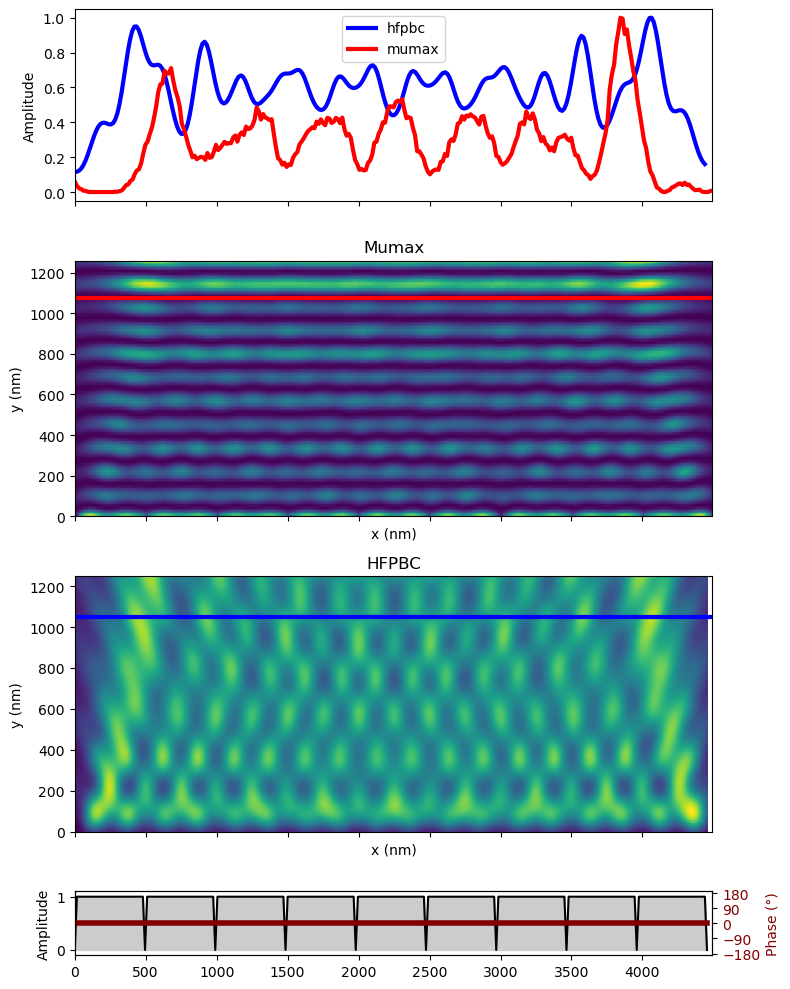

In [26]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=495,  # nm
        input_width=240*2,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/widthx2/d=500.npz",
        plots=True,
        one_d_phase=False
    )

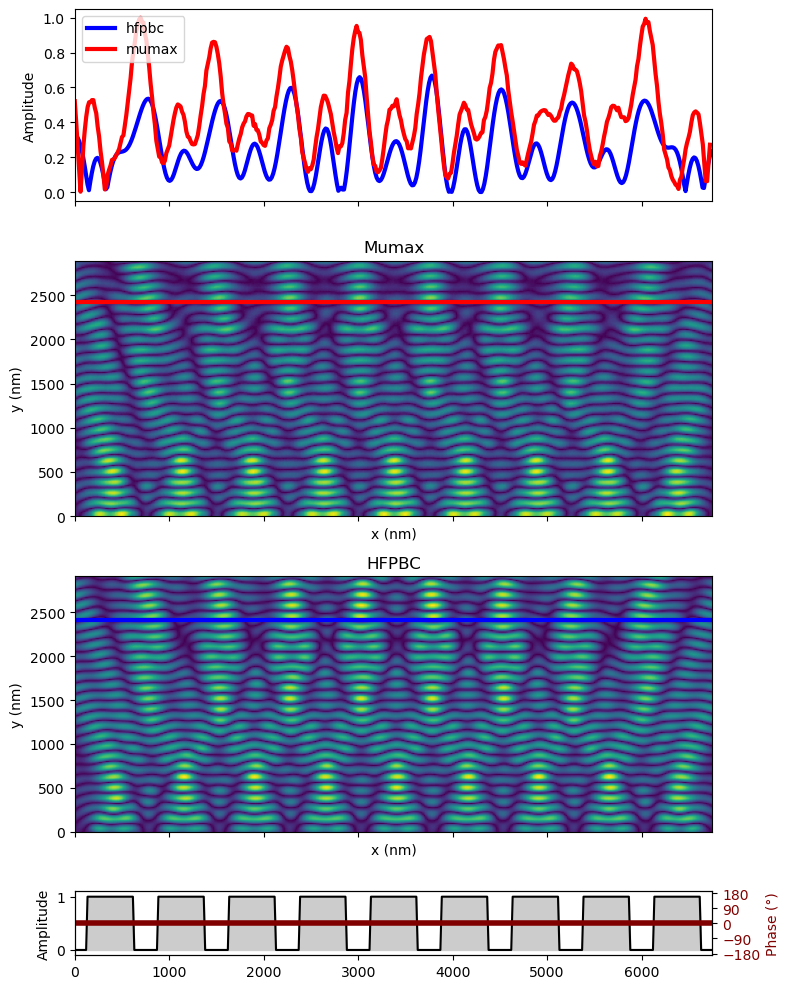

In [85]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=750,  # nm
        input_width=240*2,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=500,  # nm
        w_axhl=1,
        npz_path = "mumax_data/widthx2/d=750.npz",
        plots=True,
        one_d_phase=False
    )

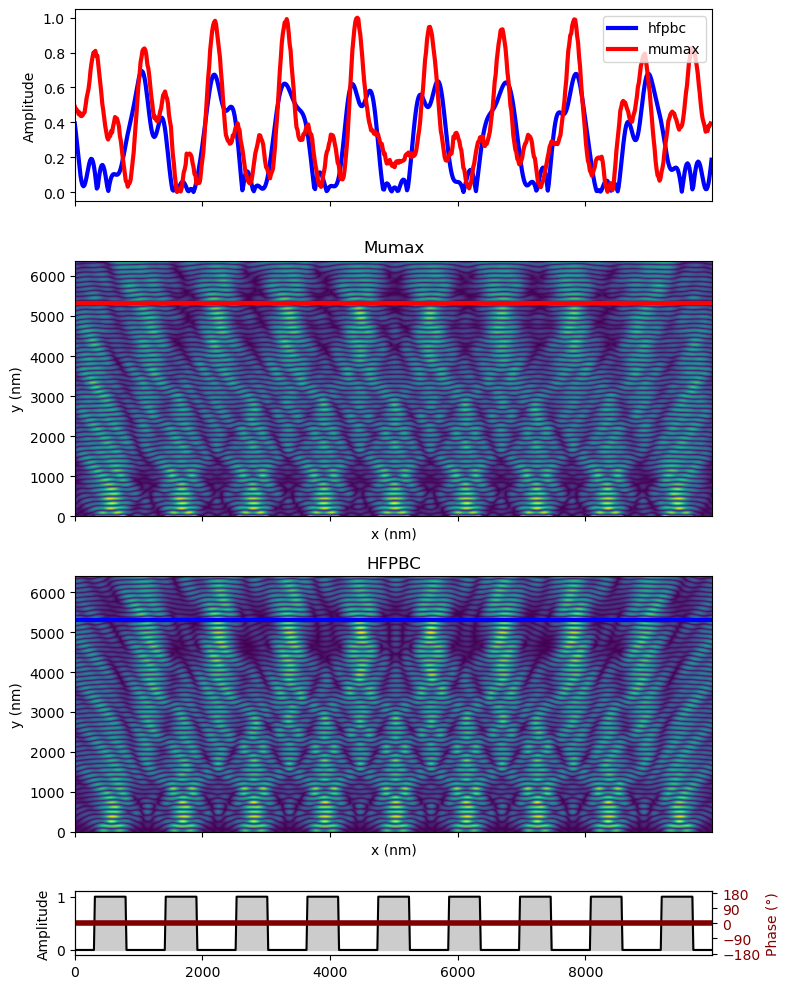

In [83]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1110,  # nm
        input_width=240*2,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=1100,  # nm
        w_axhl=1,
        npz_path = "mumax_data/widthx2/d=1111.npz",
        plots=True,
        one_d_phase=False
    )

# normal width

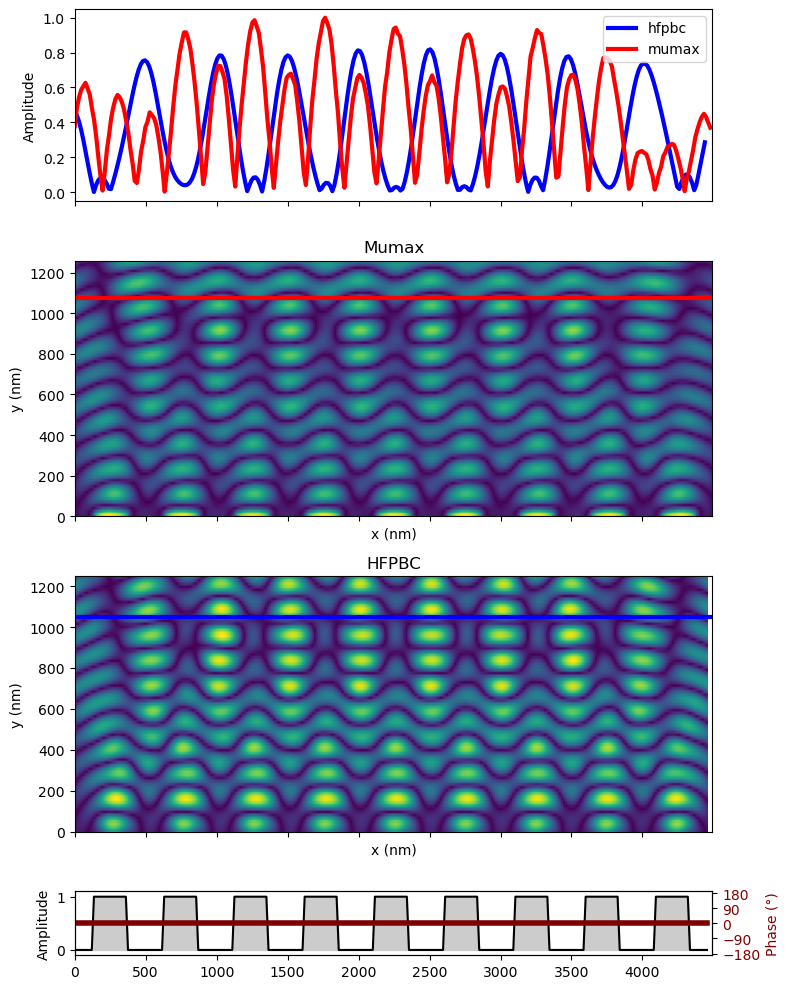

In [88]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=495,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/normal_width/500.npz",
        plots=True,
        one_d_phase=False
    )

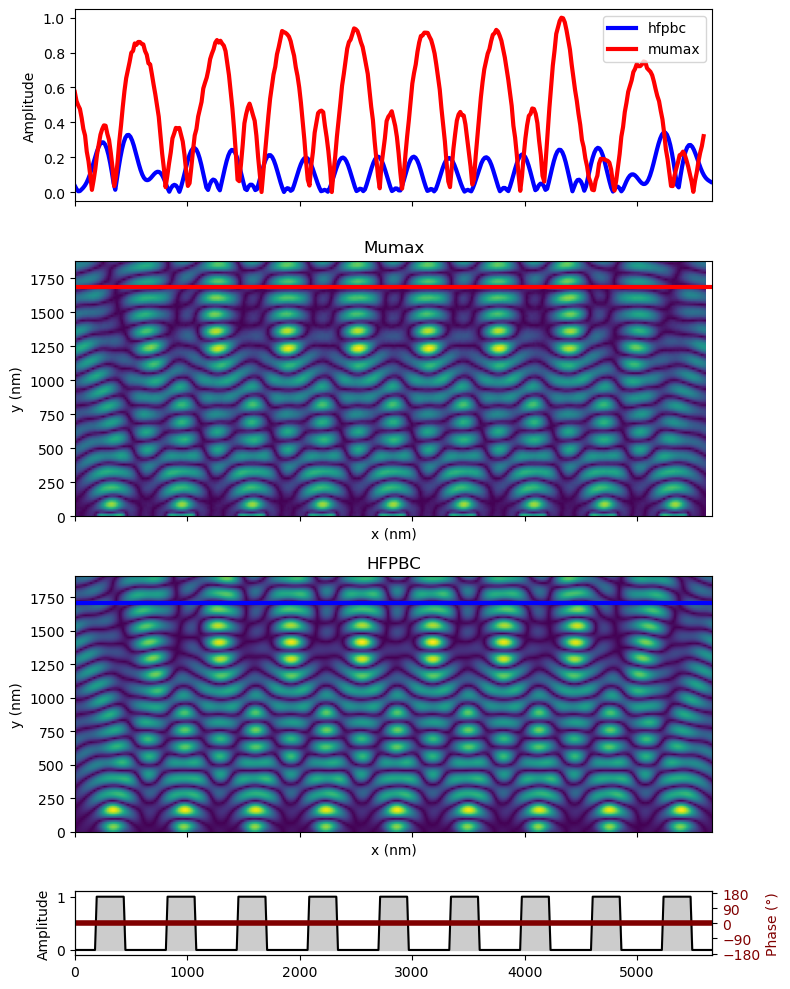

In [87]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=630,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/normal_width/625.npz",
        plots=True,
        one_d_phase=False
    )

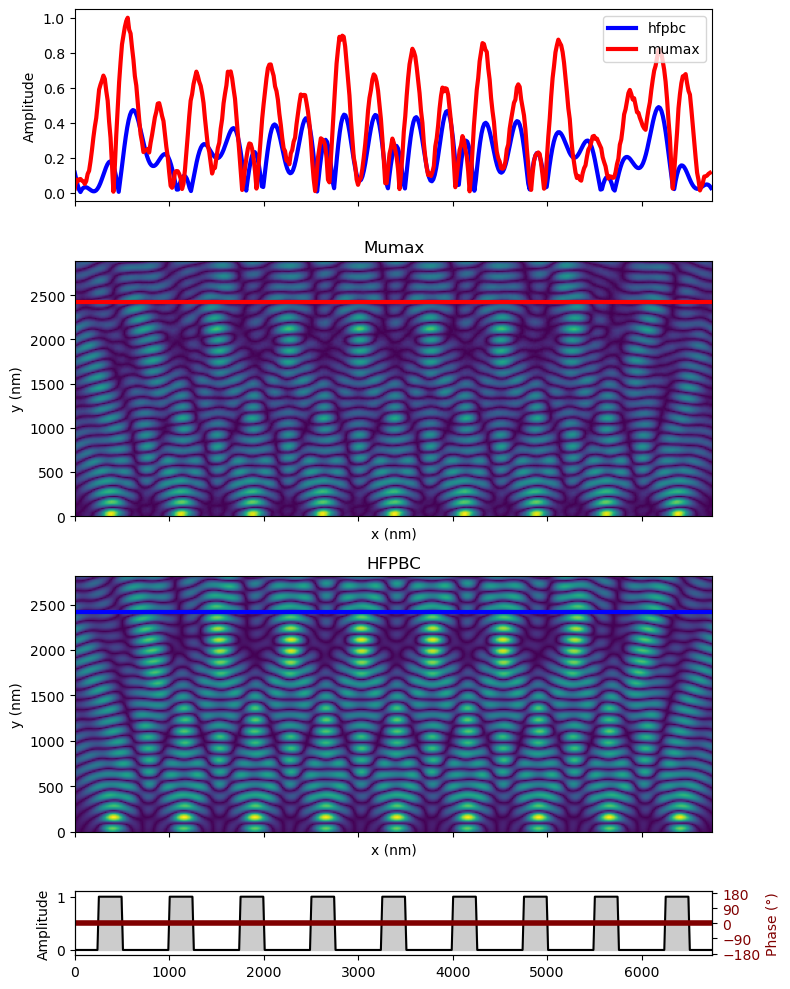

In [89]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=750,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=400,  # nm
        w_axhl=1,
        npz_path = "mumax_data/normal_width/750.npz",
        plots=True,
        one_d_phase=False
    )

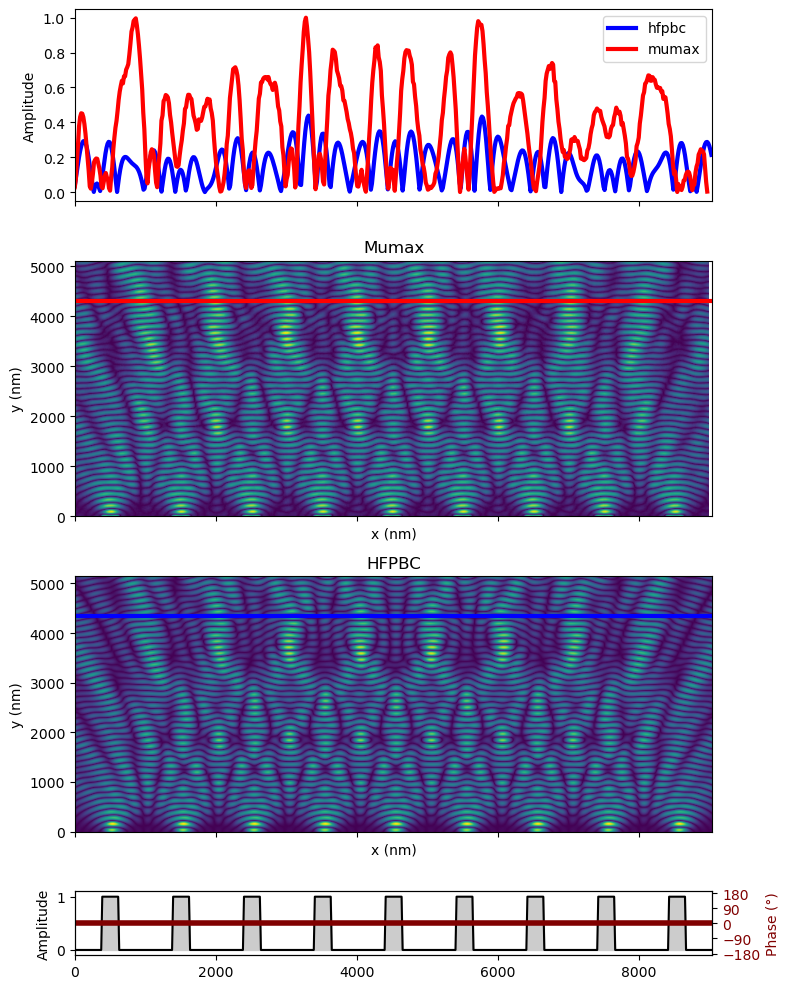

In [90]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1005,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=0,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=800,  # nm
        w_axhl=1,
        npz_path = "mumax_data/normal_width/1000.npz",
        plots=True,
        one_d_phase=False
    )

In [3]:
def display_metadata(npz_path):
    loaded = np.load(file=npz_path, allow_pickle=True)
    metadata = loaded["metadata"].item()
    
    metadata_str = "\n".join([f"{key}: {value}" for key, value in metadata.items()])
    print(metadata_str)

display_metadata("mumax_data/intensities/001111100.npz")

Aex: 3.5e-12
AutoMeshx: True
AutoMeshy: True
B_ext: 0xc000225b30
MaxDt: 1e-13
MaxErr: 1e-08
Msat: 140000
Nx: 384
Ny: 175
Nz: 1
PBCx: 1
PBCy: 1
PBCz: 0
Tx: 5.925e-06
Ty: 2.6256465517241377e-06
Tz: 5e-08
absorbing_length: 40
alpha0: 0
alpha_max: 0.5
alpha_step: 40
alpha_step_size: 2
amps: 0.001
dalpha: 0.0125
distance_between_inputs: 5.25e-07
distance_between_inputs_cells: 34
dx: 1.5429687499999998e-08
dy: 1.5e-08
dz: 5e-08
end_time: Thu Oct 10 16:45:56 CEST 2024
f: 2600000000
gpu: NVIDIA GeForce RTX 3080 Ti(11937MB), CUDA Driver 12.6, cc=8.6
input1: 0
input2: 0
input3: 1
input4: 1
input5: 1
input6: 1
input7: 1
input8: 0
input9: 0
input_width: 2.4e-07
input_width_cells: 16
mask: [0xc0005fa000 0xc000700000 0xc0002a2000] [384 175 1] 1
number_of_inputs: 9
port: 35368
scale: 0.15
spin_wave_speed: 603.2
start_time: 2024-10-10T16:45:35.467100702+02:00
steps: 29605
t_sampl: 3.846153846153846e-11
talbot_length: 1.188038793103448e-06
time_to_travel: 2.954340500091465e-09
total_time: 21.243413027s

# INTENSITIES

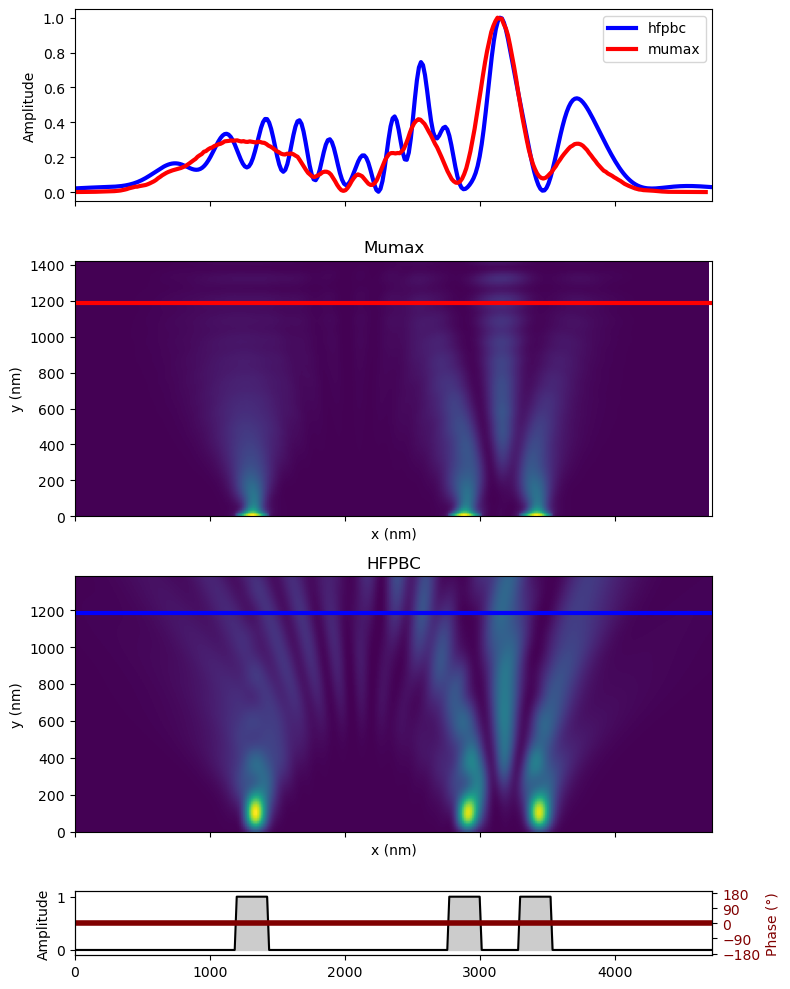

In [42]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,4,5,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001001100.npz",
        plots=True,
        one_d_phase=False
    )

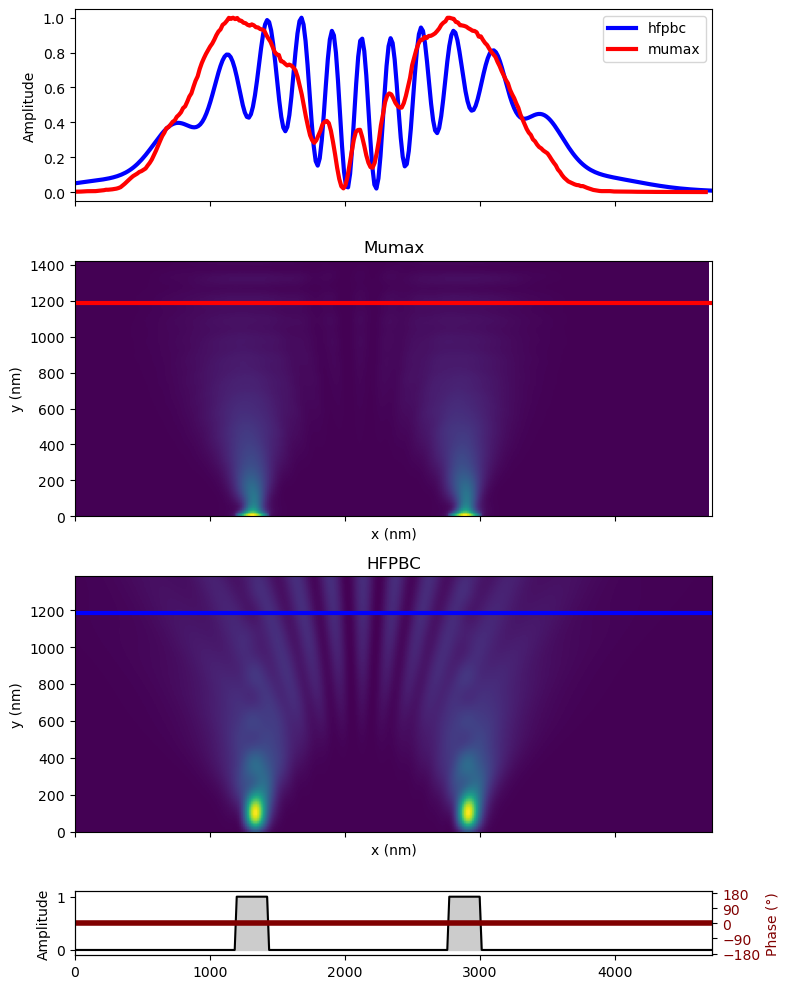

In [43]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,4,5,7,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001001000.npz",
        plots=True,
        one_d_phase=False
    )

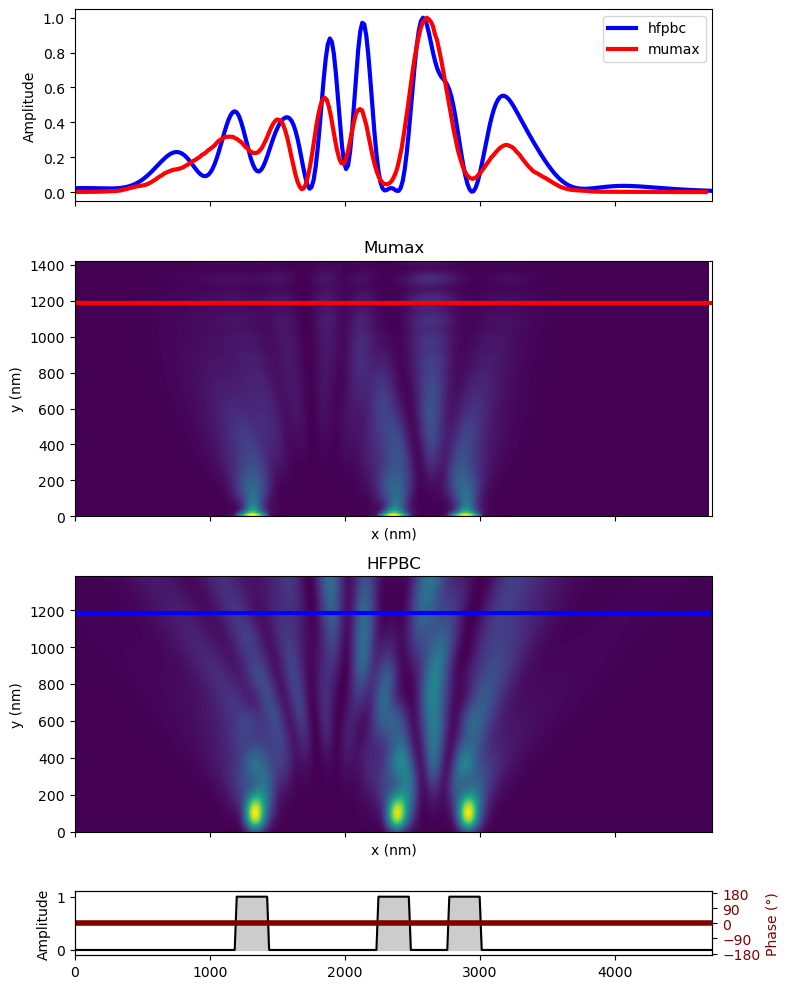

In [44]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,4,7,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001011000.npz",
        plots=True,
        one_d_phase=False
    )

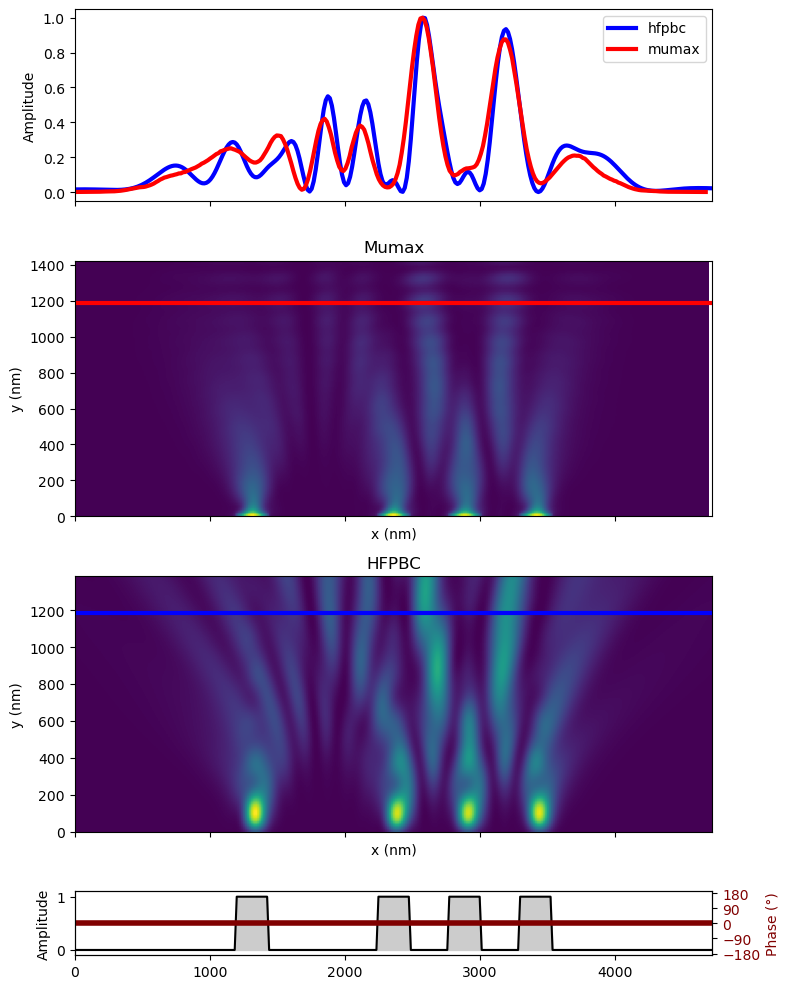

In [45]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,4,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001011100.npz",
        plots=True,
        one_d_phase=False
    )

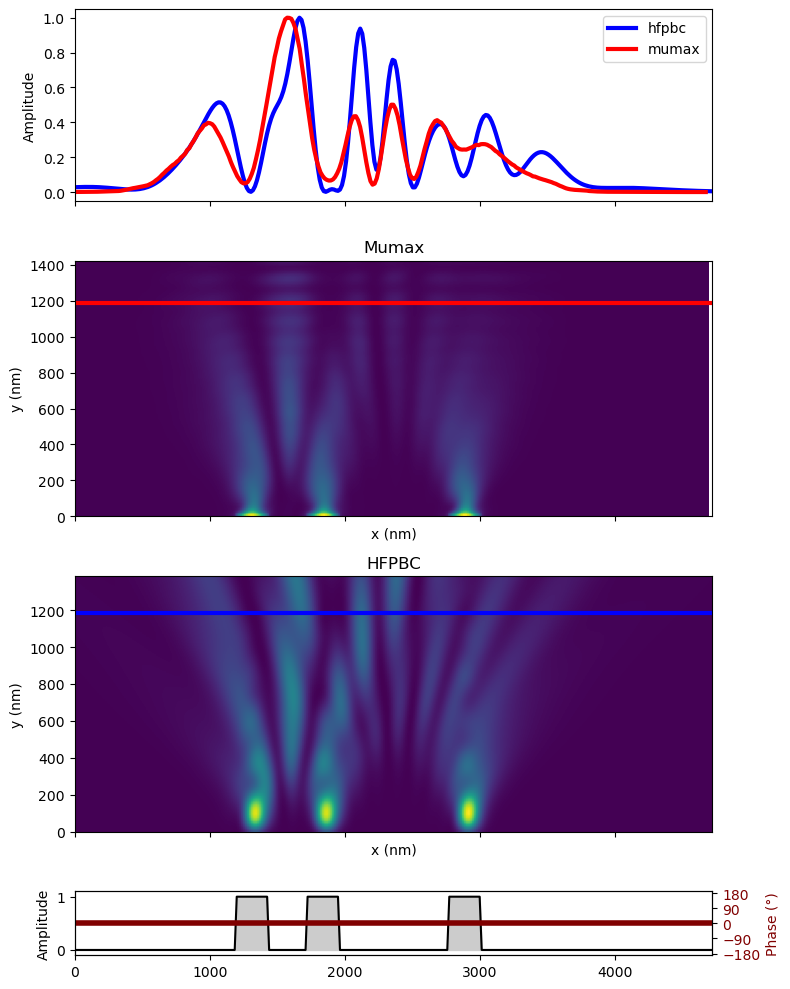

In [46]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,5,7,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001101000.npz",
        plots=True,
        one_d_phase=False
    )

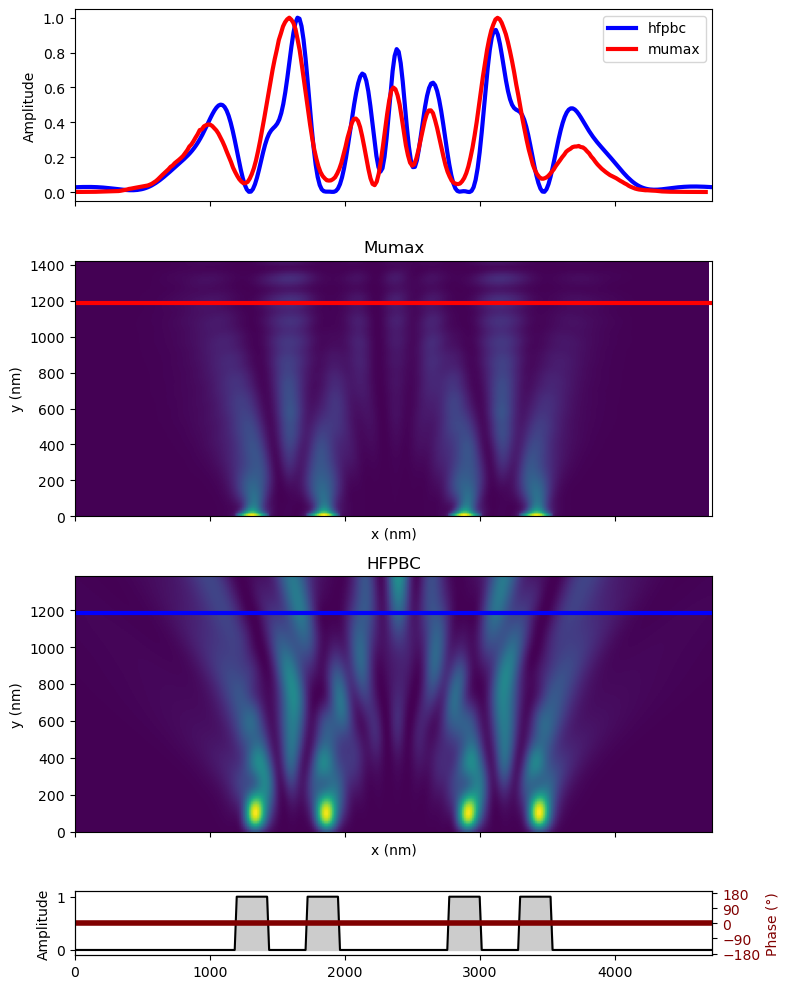

In [47]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,5,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001101100.npz",
        plots=True,
        one_d_phase=False
    )

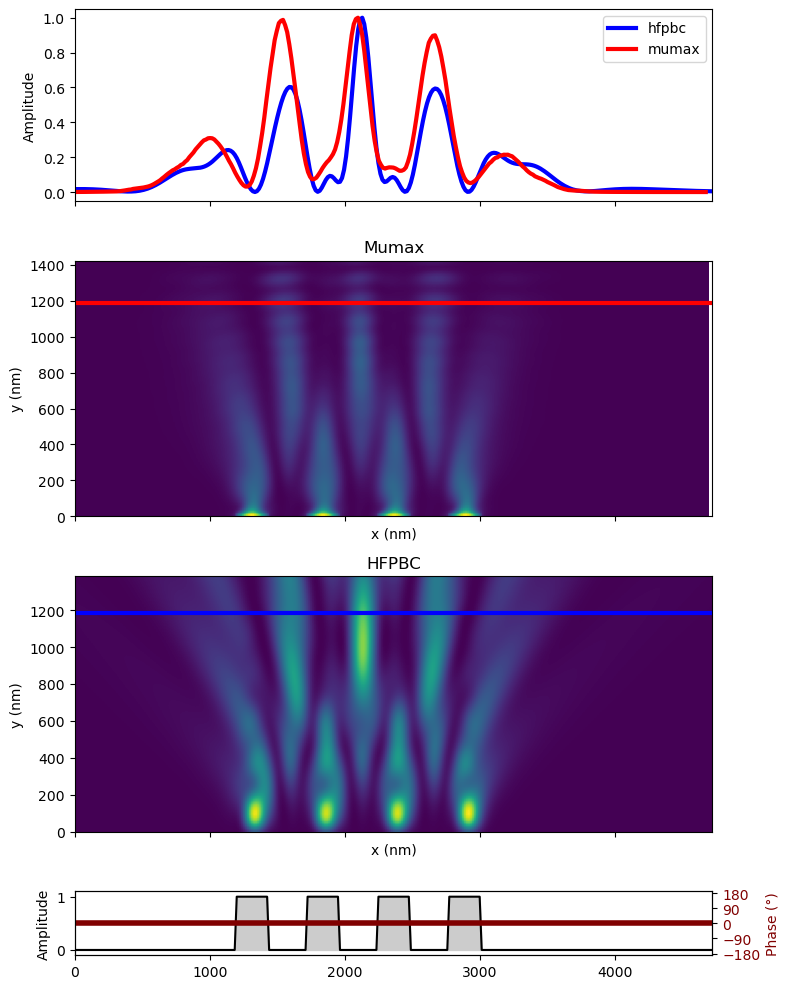

In [48]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,7,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001111000.npz",
        plots=True,
        one_d_phase=False
    )

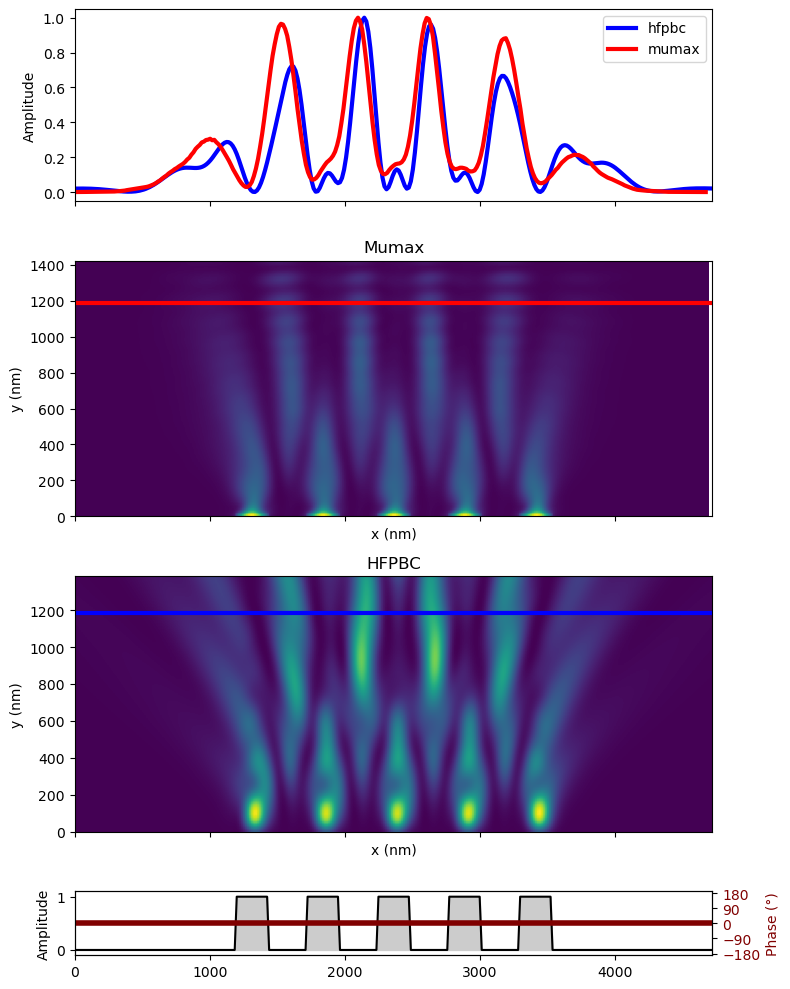

In [49]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs=[1,2,8,9],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/intensities/001111100.npz",
        plots=True,
        one_d_phase=False
    )

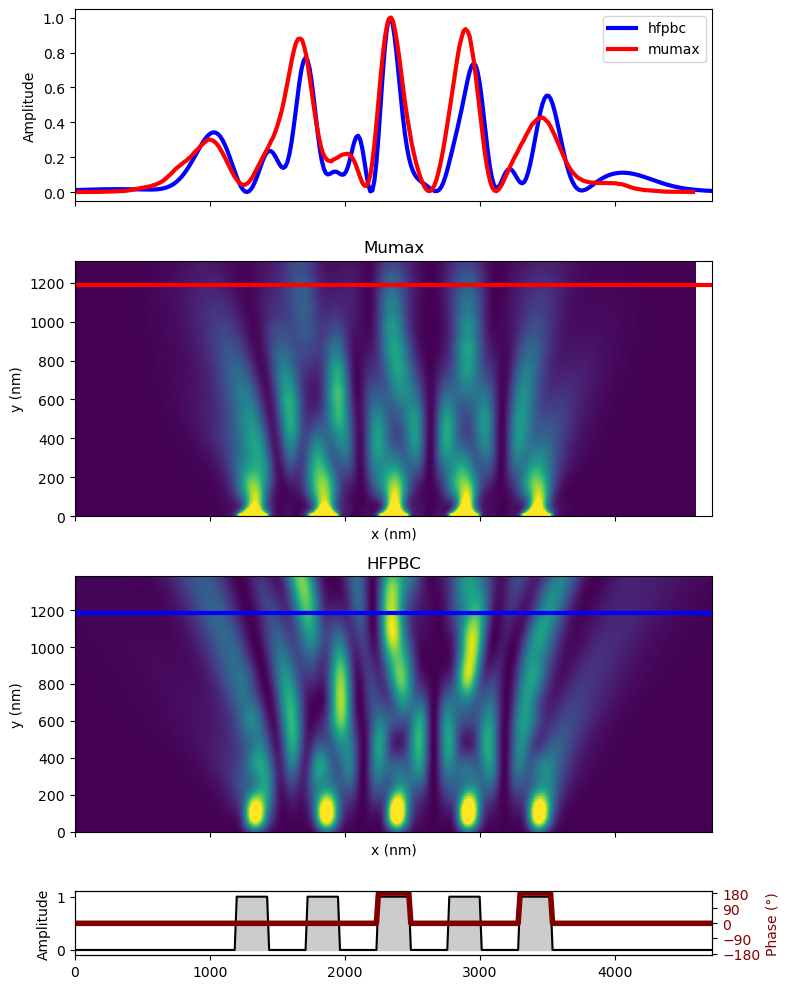

In [30]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs_amp=[1,2,8,9],
        active_inputs_phase=[5,7],
        active_input_phase_shift=np.pi,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/new_intensities/001111100_0_0_0_0_1_0_1_0_0.npz",
        plots=True,
        one_d_phase=False
    )

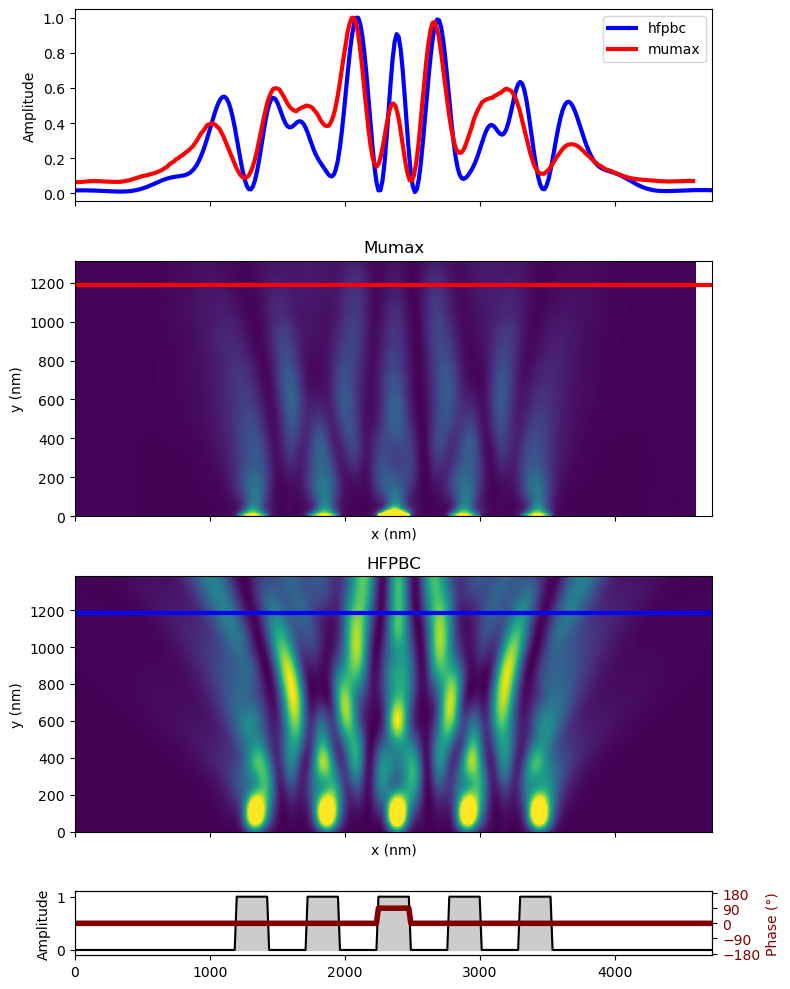

In [21]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=525,  # nm
        input_width=240,  # nm
        active_inputs_amp=[1,2,8,9],
        active_inputs_phase=[5],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=200,  # nm
        w_axhl=1,
        npz_path = "mumax_data/new_intensities/001111100_0_0_0_0_0.5_0_0_0_0.npz",
        plots=True,
        one_d_phase=False
    )